In [1]:
import sklearn
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

/opt/homebrew/anaconda3/envs/projectp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
PENGUIN_DATASET = '../data/penguin/penguins_final_with_era5.csv'
penguin_df = pd.read_csv(PENGUIN_DATASET)

In [62]:
# filter df for adelie penguins and king george island
#df = penguin_df[(penguin_df['common_name'] == 'Adelie Penguin') & (penguin_df['colony_name'] == 'King George Island')]
df = penguin_df[(penguin_df['common_name'] == 'Adelie Penguin')]

In [63]:
df['date_gmt'] = pd.to_datetime(df['date_gmt'])
df = df.sort_values(by='date_gmt')

# Feature Engineering
df['day_of_year'] = df['date_gmt'].dt.dayofyear
df['week_of_year'] = df['date_gmt'].dt.isocalendar().week
df['month'] = df['date_gmt'].dt.month

# Create lag features for 'tp' and 't2m'
for lag in range(1, 4):
    df[f'tp_lag_{lag}'] = df['tp'].shift(lag)
    df[f't2m_lag_{lag}'] = df['t2m'].shift(lag)

# Cyclical features for temporal variables
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.0)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.0)
df['week_of_year_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52.0)
df['week_of_year_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52.0)

# Add lag features for additional variables
for lag in range(1, 4):
    df[f'sst_lag_{lag}'] = df['sst'].shift(lag)
    df[f'siconc_lag_{lag}'] = df['siconc'].shift(lag)
    df[f'sd_lag_{lag}'] = df['sd'].shift(lag)
    df[f'rsn_lag_{lag}'] = df['rsn'].shift(lag)
    df[f'avg_smr_lag_{lag}'] = df['avg_smr'].shift(lag)

# Rolling averages and cumulative sums for additional variables
df['sst_rolling_7'] = df['sst'].rolling(window=7, min_periods=1).mean()
df['siconc_rolling_7'] = df['siconc'].rolling(window=7, min_periods=1).mean()
df['sd_cumsum'] = df['sd'].cumsum()
df['rsn_cumsum'] = df['rsn'].cumsum()

# Drop rows with missing values
df = df.dropna()

# Define feature set and target variable
features = [
    'tp', 't2m', 'day_of_year_sin', 'day_of_year_cos',
    'week_of_year_sin', 'week_of_year_cos', 'sst', 'siconc', 
    'tp_lag_1', 'tp_lag_2', 'tp_lag_3',
    't2m_lag_1', 't2m_lag_2', 't2m_lag_3', 'sst_lag_1', 'sst_lag_2', 
    'sst_lag_3', 'siconc_lag_1', 'siconc_lag_2', 'siconc_lag_3'
]
target = 'km_to_colony_mean'

X = df[features]
y = df[target]

X100 = shap.utils.sample(X, 100) # 100 samples for use in Shapley value calculations

# Standardize features
scaler = StandardScaler()
scaled_features = ['sst', 'siconc', 'tp', 't2m']
#X[scaled_features] = scaler.fit_transform(X[scaled_features])
#X_scaled = scaler.fit_transform(X)

# Ridge and Lasso models
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store evaluation metrics
ridge_r2_scores = []
ridge_rmse_scores = []
lasso_r2_scores = []
lasso_rmse_scores = []

# Model training and evaluation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ridge Regression
    ridge_model.fit(X_train, y_train)
    ridge_y_pred = ridge_model.predict(X_test)
    ridge_r2_scores.append(r2_score(y_test, ridge_y_pred))
    ridge_rmse_scores.append(np.sqrt(mean_squared_error(y_test, ridge_y_pred)))

    # Lasso Regression
    lasso_model.fit(X_train, y_train)
    lasso_y_pred = lasso_model.predict(X_test)
    lasso_r2_scores.append(r2_score(y_test, lasso_y_pred))
    lasso_rmse_scores.append(np.sqrt(mean_squared_error(y_test, lasso_y_pred)))

# Print results
print(f"Ridge Average R^2 Score: {np.mean(ridge_r2_scores):.3f}")
print(f"Ridge Average RMSE: {np.mean(ridge_rmse_scores):.3f}")
print(f"Lasso Average R^2 Score: {np.mean(lasso_r2_scores):.3f}")
print(f"Lasso Average RMSE: {np.mean(lasso_rmse_scores):.3f}")

# Save and print model coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Ridge Coef': ridge_model.coef_,
    'Lasso Coef': lasso_model.coef_
})
#print(coefficients)

coefficients['Ridge Importance'] = coefficients['Ridge Coef'].abs()
coefficients['Lasso Importance'] = coefficients['Lasso Coef'].abs()

# Sort by importance (descending order)
ridge_sorted = coefficients.sort_values(by='Ridge Importance', ascending=False)
lasso_sorted = coefficients.sort_values(by='Lasso Importance', ascending=False)

# Print sorted coefficients
#print("Ridge Coefficients Sorted by Importance:")
#print(ridge_sorted[['Feature', 'Ridge Coef', 'Ridge Importance']])

print("\nLasso Coefficients Sorted by Importance:")
print(lasso_sorted[['Feature', 'Lasso Coef', 'Lasso Importance']])

Ridge Average R^2 Score: 0.150
Ridge Average RMSE: 184.081
Lasso Average R^2 Score: 0.135
Lasso Average RMSE: 191.224

Lasso Coefficients Sorted by Importance:
             Feature   Lasso Coef  Lasso Importance
2    day_of_year_sin  1134.125876       1134.125876
4   week_of_year_sin  -923.588776        923.588776
5   week_of_year_cos   400.164482        400.164482
7             siconc   283.906366        283.906366
3    day_of_year_cos  -249.814919        249.814919
6                sst  -100.099173        100.099173
19      siconc_lag_3   -69.003798         69.003798
16         sst_lag_3   -20.537767         20.537767
1                t2m   -14.115165         14.115165
17      siconc_lag_1   -11.317210         11.317210
18      siconc_lag_2   -11.215549         11.215549
14         sst_lag_1    -9.137402          9.137402
11         t2m_lag_1     8.901166          8.901166
15         sst_lag_2    -8.633339          8.633339
12         t2m_lag_2     5.919195          5.919195
13      

/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_9831/2064869687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_gmt'] = pd.to_datetime(df['date_gmt'])
/opt/homebrew/anaconda3/envs/projectp/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.727e+04, tolerance: 1.134e+04
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/anaconda3/envs/projectp/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

In [60]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Daily Cohort Movement Regression for Adelie Penguins

This script aggregates penguin trace data at the daily level and uses the daily mean
of 'km_to_colony_mean' as a proxy for cohort movement. It then fits Ridge and Lasso regression models
(using time series cross-validation) to predict daily cohort movement from meteorological and temporal features.
The script also demonstrates how you might add cyclical (sine/cosine) basis functions if additional flexibility is desired.
  
Required packages: pandas, numpy, scikit-learn, matplotlib, shap (optional), etc.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# ----------------------------
# Optionally, define a basis function creator
def create_basis(x, num_harmonics=2):
    """
    Generates sine and cosine basis functions up to a specified number of harmonics.
    Here, x is expected to be a 1D numpy array representing day-of-year.
    """
    # You may adjust normalization if needed.
    # For example, normalize day-of-year (1 to 365) to [0, 2*pi].
    x_norm = (x / 365.0) * 2 * np.pi  
    features = [np.ones(len(x_norm))]  # intercept
    for n in range(1, num_harmonics + 1):
        features.append(np.sin(n * x_norm))
        features.append(np.cos(n * x_norm))
    return np.column_stack(features)
# ----------------------------

# ----------------------------
# Load and sort data
#df = pd.read_csv("../data/penguin/penguins_final_with_era5.csv")
df['date_gmt'] = pd.to_datetime(df['date_gmt'])
df = df.sort_values(by='date_gmt')

# ----------------------------
# Feature Engineering on the Raw Data
df['day_of_year'] = df['date_gmt'].dt.dayofyear
df['month'] = df['date_gmt'].dt.month
# (Other features, e.g., week_of_year, could be added if desired.)

# ----------------------------
# Aggregate Data Daily (Summarize the Cohort Movement)
# We aggregate by the date (ignoring time). You might consider grouping by colony if needed.
df['date'] = df['date_gmt'].dt.date
# For each day, compute mean km_to_colony_mean and means of meteorological variables, plus record count.
daily_df = df.groupby('date').agg({
    'km_to_colony_mean': 'mean',
    'tp': 'mean',
    't2m': 'mean',
    'sst': 'mean',
    'siconc': 'mean',
    'sd': 'mean',
    'rsn': 'mean',
    'avg_smr': 'mean',
    'month': 'first',  # All rows in the group have same month? (or use mean)
    'day_of_year': 'first'  # All rows in the group have same day_of_year? (or use mean)
}).reset_index()
daily_df['n_records'] = df.groupby('date').size().values

# Optionally, filter out days with very few observations (if needed)
min_records_per_day = 5
daily_df = daily_df[daily_df['n_records'] >= min_records_per_day]

# ----------------------------
# Create additional temporal features
daily_df['day_of_year_sin'] = np.sin(2 * np.pi * daily_df['day_of_year'] / 365.0)
daily_df['day_of_year_cos'] = np.cos(2 * np.pi * daily_df['day_of_year'] / 365.0)
daily_df['month_sin'] = np.sin(2 * np.pi * daily_df['month'] / 12.0)
daily_df['month_cos'] = np.cos(2 * np.pi * daily_df['month'] / 12.0)

# Optionally, add harmonic basis functions for day-of-year:
# basis = create_basis(daily_df['day_of_year'].values, num_harmonics=2)
# For illustration, we could append these columns to daily_df if desired.
# for i in range(basis.shape[1]):
#     daily_df[f'harmonic_{i}'] = basis[:, i]

# ----------------------------
# Define feature set and target.
# We use daily averages for predictors.
features = [
    'siconc', 'sst','tp', 't2m', 'sd', 'rsn', 'avg_smr', # siconc
    #'day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos'
    #, 'harmonic_0', 'harmonic_1', 'harmonic_2', 'harmonic_3', 'harmonic_4'  # if added
]
target = 'km_to_colony_mean'  # Daily mean distance to colony

X = daily_df[features]
y = daily_df[target]

# ----------------------------
# Standardize selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# ----------------------------
# TimeSeriesSplit for daily data (ensure temporal order)
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Ridge and Lasso regression models
from sklearn.linear_model import Ridge, Lasso
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

ridge_r2 = []
ridge_rmse = []
lasso_r2 = []
lasso_rmse = []

for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Ridge
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    ridge_r2.append(r2_score(y_test, y_pred_ridge))
    ridge_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
    
    # Lasso
    lasso_model.fit(X_train, y_train)
    y_pred_lasso = lasso_model.predict(X_test)
    lasso_r2.append(r2_score(y_test, y_pred_lasso))
    lasso_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

print(f"Ridge Average R²: {np.mean(ridge_r2):.3f}")
print(f"Ridge Average RMSE: {np.mean(ridge_rmse):.3f}")
print(f"Lasso Average R²: {np.mean(lasso_r2):.3f}")
print(f"Lasso Average RMSE: {np.mean(lasso_rmse):.3f}")

# ----------------------------
# Print model coefficients for Lasso (for interpretability)
coefficients = pd.DataFrame({
    'Feature': features,
    'Lasso Coef': lasso_model.coef_
})
coefficients['Lasso Importance'] = coefficients['Lasso Coef'].abs()
lasso_sorted = coefficients.sort_values(by='Lasso Importance', ascending=False)
print("\nLasso Coefficients Sorted by Importance:")
print(lasso_sorted[['Feature', 'Lasso Coef', 'Lasso Importance']])

# ----------------------------
# Plot daily actual vs predicted using the best performing model (e.g., Ridge)
daily_df['ridge_pred'] = ridge_model.predict(X_scaled)
plt.figure(figsize=(12,6))
plt.plot(daily_df['date'], daily_df[target], label='Actual', marker='o')
plt.plot(daily_df['date'], daily_df['ridge_pred'], label='Predicted (Ridge)', marker='x')
plt.xlabel("Date")
plt.ylabel("Daily Mean km_to_colony")
plt.title("Daily Cohort Movement: Actual vs. Predicted (Ridge)")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_9831/1140187806.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_gmt'] = pd.to_datetime(df['date_gmt'])


ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Interpretation using SHARP values

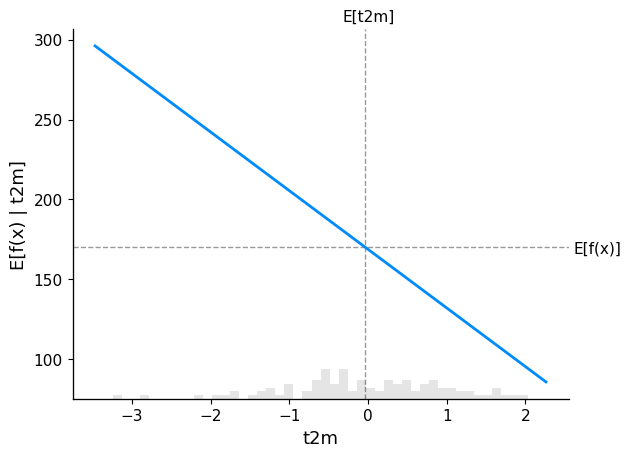

In [32]:
shap.partial_dependence_plot(
    "t2m",
    ridge_model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In [29]:
X["week_of_year_sin"] = X["week_of_year_sin"].astype(np.float64)
X["week_of_year_cos"] = X["week_of_year_cos"].astype(np.float64)
X100["week_of_year_sin"] = X100["week_of_year_sin"].astype(np.float64)
X100["week_of_year_cos"] = X100["week_of_year_cos"].astype(np.float64)


/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_83360/4247435490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["week_of_year_sin"] = X["week_of_year_sin"].astype(np.float64)
/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_83360/4247435490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["week_of_year_cos"] = X["week_of_year_cos"].astype(np.float64)


PermutationExplainer explainer: 1706it [00:12, 28.20it/s]                           


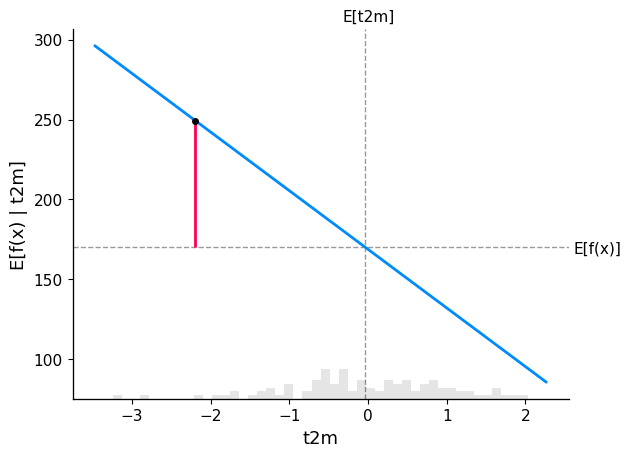

In [33]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(ridge_model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "t2m",
    ridge_model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

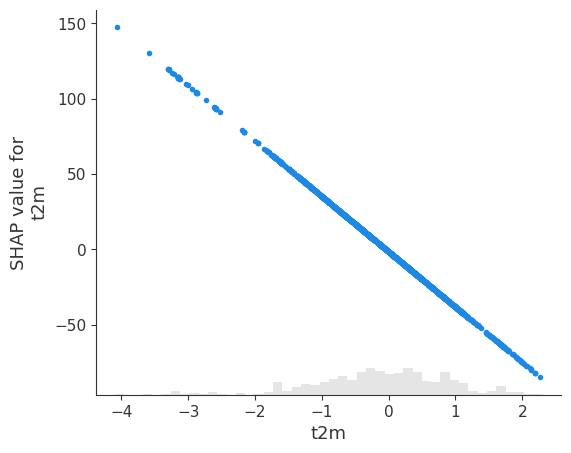

In [34]:
shap.plots.scatter(shap_values[:, "t2m"])

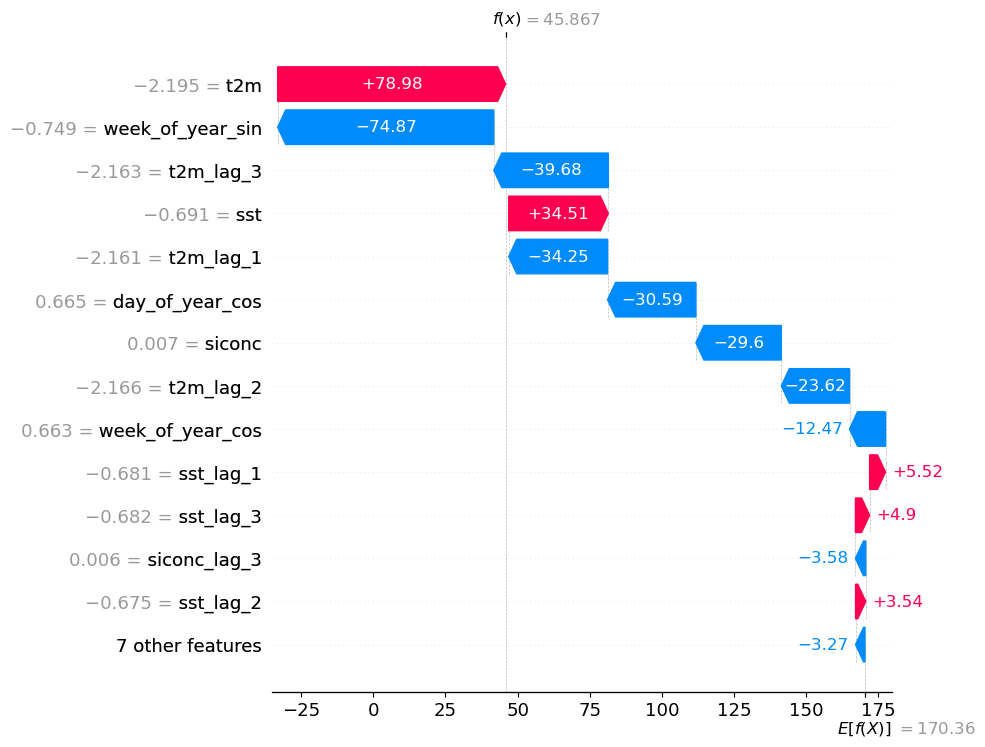

In [31]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

### Random Forest and XGBoost 

In [12]:
rf_model = RandomForestRegressor(
    n_estimators=200,  # Number of trees
    max_depth=20,      # Maximum depth of trees
    random_state=42    # Reproducibility
)

# To store evaluation metrics
rf_r2_scores = []
rf_rmse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Random Forest
    rf_model.fit(X_train, y_train)
    rf_y_pred = rf_model.predict(X_test)
    
    # Evaluate Random Forest
    rf_r2_scores.append(r2_score(y_test, rf_y_pred))
    rf_rmse_scores.append(np.sqrt(mean_squared_error(y_test, rf_y_pred)))

# Print Random Forest results
print(f"Random Forest Average R^2 Score: {np.mean(rf_r2_scores):.3f}")
print(f"Random Forest Average RMSE: {np.mean(rf_rmse_scores):.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_,
}).sort_values(by='Importance', ascending=False)
print(feature_importance)


Random Forest Average R^2 Score: 0.572
Random Forest Average RMSE: 66.827
             Feature  Importance
7             siconc    0.814955
2    day_of_year_sin    0.108527
6                sst    0.030119
3    day_of_year_cos    0.008359
1                t2m    0.006266
0                 tp    0.005239
12         t2m_lag_2    0.002440
8           tp_lag_1    0.002417
16         sst_lag_3    0.002386
14         sst_lag_1    0.002232
15         sst_lag_2    0.002223
9           tp_lag_2    0.002105
4   week_of_year_sin    0.002060
13         t2m_lag_3    0.001960
10          tp_lag_3    0.001886
17      siconc_lag_1    0.001776
11         t2m_lag_1    0.001709
19      siconc_lag_3    0.001600
18      siconc_lag_2    0.001138
5   week_of_year_cos    0.000602


In [ ]:
xgb_model = XGBRegressor(
    n_estimators=100,  # Number of trees
    max_depth=6,       # Maximum depth of each tree
    learning_rate=0.1, # Learning rate
    random_state=42    # Seed for reproducibility
)

# To store evaluation metrics
xgb_r2_scores = []
xgb_rmse_scores = []

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train XGBoost model
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = xgb_model.predict(X_test)
    
    # Evaluate model
    xgb_r2_scores.append(r2_score(y_test, y_pred))
    xgb_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Print XGBoost results
print(f"XGBoost Average R^2 Score: {np.mean(xgb_r2_scores):.3f}")
print(f"XGBoost Average RMSE: {np.mean(xgb_rmse_scores):.3f}")

xgb_feature_importance = xgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_feature_importance
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

XGBoost Average R^2 Score: 0.579
XGBoost Average RMSE: 67.812
             Feature  Importance
7             siconc    0.753624
2    day_of_year_sin    0.164487
6                sst    0.018236
3    day_of_year_cos    0.005827
16         sst_lag_3    0.005519
12         t2m_lag_2    0.005385
1                t2m    0.004909
17      siconc_lag_1    0.004699
19      siconc_lag_3    0.004198
9           tp_lag_2    0.003926
11         t2m_lag_1    0.003782
14         sst_lag_1    0.003660
8           tp_lag_1    0.003460
13         t2m_lag_3    0.003420
15         sst_lag_2    0.003396
0                 tp    0.003388
10          tp_lag_3    0.003205
18      siconc_lag_2    0.003134
5   week_of_year_cos    0.001745
4   week_of_year_sin    0.000000
